In [1]:
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
from fonte_dados.fabrica import FabricaFonteDados
from repository.resultado import ResultadoRepo
from resultados import resultados_explorer
from resultados import topico_dominante
from treinamento.treinamento_lda import TreinamentoLda
from util.constants import NERDS_VIAJANTES, WIKIPEDIA

import numpy as np
import pandas as pd

## Carregamento de dados para treinamento

In [3]:
fabrica = FabricaFonteDados()
num_topics = 57
passes = 2
fonte_dados = fabrica.get_fonte_dados(NERDS_VIAJANTES)
fonte_dados.carregar_dados()
ners_viajantes = fonte_dados
documentos = fonte_dados.get_tokens()

wikipedia = fabrica.get_fonte_dados(WIKIPEDIA)
wikipedia.carregar_dados()

## Executa treinamento de modelo

In [ ]:
treinamento_lda = TreinamentoLda(num_topics=num_topics, passes=passes)
resultado_lda = treinamento_lda.ajustar_modelo(documentos, alpha=0.01, eta=0.01)
lda_model = resultado_lda.modelo_lda
corpus = resultado_lda.corpus

# lda_model.print_topics()

Ajustando modelo com 57 topicos e 2 passes


## Análise de tópicos

### Tópicos dominantes e seu percentual de contribuição em cada documento

Em modelos LDA, cada documento é composto de múltiplos tópicos mas tipicamente apenas um tópico é dominante. O código a seguir extrai este tópico dominante para cada texto e mostra o peso do tópico e suas palavras chave formatados.

In [ ]:
df_topic_sents_keywords = topico_dominante.format_topics_sentences(ldamodel=lda_model, corpus=resultado_lda.corpus, texts=documentos)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.9949,"bonit, temp, cidad, vist, cervej, aind, pra, g...","[santiag, mus, art, pré, colombi, vár, mes, pe..."
1,1,6.0,0.9947,"congr, cidad, ambi, marin, noss, opç, cad, blo...","[santiag, bacan, dentr, opç, divers, blog, aqu..."
2,2,8.0,0.9924,"glaci, temp, pouc, lag, seward, vist, pais, ai...","[palaci, moned, soment, moned, chilen, santiag..."
3,3,55.0,0.4061,"câm, cidad, loj, estanh, cen, expos, são, peç,...","[hoj, seç, seman, câm, ent, últ, chil, argenti..."
4,4,30.0,0.9891,"parqu, ônibu, temp, montanh, expos, fiz, cent,...","[monument, valley, unid, dentr, indígen, trib,..."
5,5,1.0,0.9958,"sorvet, cidad, aind, histór, mund, uma, pouc, ...","[cristób, 880m, nível, 280m, nível, santiag, s..."
6,6,54.0,0.8293,"routeburn, track, hut, mus, pais, câm, porqu, ...","[frutill, cidad, bel, alemã, não, muse, alemán..."
7,7,4.0,0.9936,"argentin, prat, boa, bariloch, cord, cidad, ma...","[qu, país, boa, sempr, argentin, buen, air, de..."
8,8,17.0,0.9967,"lag, parqu, barc, águ, bonit, cacho, pouc, táb...","[lag, andin, petrohué, antecipad, lug, bellav,..."
9,9,8.0,0.9113,"glaci, temp, pouc, lag, seward, vist, pais, ai...","[catedr, metropolit, santiag, atr, religi, pop..."


### O texto mais significativo de cada tópico

Algumas vezes queremos obter exemplos de textos que melhor representam um dado tópico. O código a seguir exibe as sentenças mais significativas para cada tópico
do treinamento.

In [ ]:
sent_topics_sorteddf_mallet = topico_dominante.get_most_significant_sentences(df_topic_sents_keywords)
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9943,"urs, iso, boa, câm, parqu, cinderel, moment, voad, voo, cordilh","[selv, intenç, denal, nation, park, parqu, alasc, aind, parqu, animal, inclusiv, urs, espéci, gr..."
1,1.0,0.9974,"sorvet, cidad, aind, histór, mund, uma, pouc, pesso, são, temp","[boa, gulose, princip, sorvet, sempr, sorvet, bel, horizont, cidad, dentr, sorvet, aless, uma, i..."
2,2.0,0.7644,"alt, geral, caraç, cidad, santu, igrej, santiag, parqu, matriz, ônibu","[rapid, santiag, vall, estaçã, esqu, montanh, passe, princip, cidad, ônibu, hop, hop, off, final..."
3,3.0,0.9978,"prai, bonit, mari, cidad, igrej, pouc, praç, rua, vist, fiz","[noss, fern, noronh, tour, apes, bacan, poi, noronh, fim, agênc, caminhon, 4x4, depois, turist, ..."
4,4.0,0.9936,"argentin, prat, boa, bariloch, cord, cidad, mas, afinal, portugu, jauj","[qu, país, boa, sempr, argentin, buen, air, depois, bariloch, cidad, boa, bariloch, jauj, cardáp..."
5,5.0,0.9974,"lago, lençol, maranh, cervej, cidad, parqu, águ, aind, temp, chei","[lençol, maranh, antig, junh, 2012, promoç, aére, bom, são, luí, maranh, lençol, maranh, lago, c..."
6,6.0,0.9947,"congr, cidad, ambi, marin, noss, opç, cad, blog, sit, bel","[santiag, bacan, dentr, opç, divers, blog, aquí, blog, destemper, diss, mes, mes, varand, ótim, ..."
7,7.0,0.9984,"glaci, temp, quilômetr, pouc, lad, barc, chuv, lag, bonit, jalap","[sul, argentin, chil, contém, dezen, glaci, uma, boa, barc, lag, argentin, nest, glaci, upsal, s..."
8,8.0,0.9978,"glaci, temp, pouc, lag, seward, vist, pais, aind, montanh, bonit","[patagôn, calafat, dest, estânc, dentr, opç, cristin, apes, rebanh, ovelh, porqu, dentr, áre, pa..."
9,9.0,0.9951,"animal, temp, vist, selv, expos, macr, long, lad, lag, yellowston","[yellowston, nation, park, parqu, nacion, unid, selv, sempr, chanc, animal, talv, bich, princip,..."


## Carregamento de resultados de execução

In [ ]:
resultados = resultados_explorer.find_all_resultados()

In [ ]:
resultados.head()

,_id,id_cenario,fonte_origem,id_documento_origem,titulo_documento_origem,fonte_destino,id_documento_destino,titulo_documento_destino,distancia_destino,num_topics,passes,eta,alpha,cenario_wp
0,60ff30d62d746456b8fb66b7,NERDS_VIAJANTES-WIKIPEDIA-57_topics,NERDS_VIAJANTES,11,Santiago - Museu de Arte Pré-Colombiana Fechado para Reforma,WIKIPEDIA,583521,Parque Municipal Américo Renné Giannetti,0.119204,57,2,0.005,1.0,full
1,60ff30d62d746456b8fb66b8,NERDS_VIAJANTES-WIKIPEDIA-57_topics,NERDS_VIAJANTES,60,Santiago - Restaurante Aquí Está Coco,WIKIPEDIA,5948192,Monte Gareloi,0.145067,57,2,0.005,1.0,full
2,60ff30d62d746456b8fb66b9,NERDS_VIAJANTES-WIKIPEDIA-57_topics,NERDS_VIAJANTES,111,Santiago - Palacio de la Moneda,WIKIPEDIA,788767,Antelope Canyon,0.135925,57,2,0.005,1.0,full
3,60ff30d62d746456b8fb66ba,NERDS_VIAJANTES-WIKIPEDIA-57_topics,NERDS_VIAJANTES,134,Revelando a Foto - Frutillar,WIKIPEDIA,2267833,Llanquihue,0.083628,57,2,0.005,1.0,full
4,60ff30d62d746456b8fb66bb,NERDS_VIAJANTES-WIKIPEDIA-57_topics,NERDS_VIAJANTES,167,Revelando a Foto - Monument Valley,WIKIPEDIA,3031496,Quebrada das Conchas,0.112021,57,2,0.005,1.0,full


## Comportamento da variação da semelhança por parâmetros

### Média e desvio padrão por conjunto de páginas

In [ ]:
resultados.groupby(['cenario_wp'])['distancia_destino'].agg([np.mean, np.std]).reset_index()

,cenario_wp,mean,std
0,full,0.244593,0.169004
1,gte42,0.293772,0.196154


In [ ]:
resultados.groupby(['num_topics'])['distancia_destino'].agg([np.mean, np.std]).reset_index()

,num_topics,mean,std
0,22,0.234775,0.161470
1,39,0.266610,0.173423
2,45,0.270563,0.178036
3,57,0.276523,0.184559
4,67,0.285299,0.187543
5,72,0.279334,0.191407
6,101,0.271173,0.208681


In [ ]:
resultados.groupby(['alpha'])['distancia_destino'].agg([np.mean, np.std]).reset_index()

,alpha,mean,std
0,0.01,0.299975,0.202525
1,0.10,0.327551,0.181500
2,1.00,0.180020,0.126922


In [ ]:
resultados.groupby(['eta'])['distancia_destino'].agg([np.mean, np.std]).reset_index()

,eta,mean,std
0,0.005,0.379512,0.150678
1,0.050,0.371781,0.150373
2,0.500,0.205030,0.152114
3,1.000,0.120406,0.138177


In [ ]:
resultados.groupby(['passes'])['distancia_destino'].agg([np.mean, np.std]).reset_index()

,passes,mean,std
0,2,0.265562,0.186465
1,10,0.272802,0.182900


### Distribuição de distâncias por conjunto de páginas

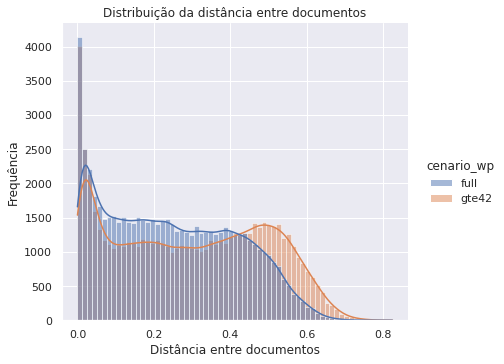

In [ ]:
import seaborn as sns
sns.set_theme()

resultados_explorer.distribuicao_distancias(resultados)

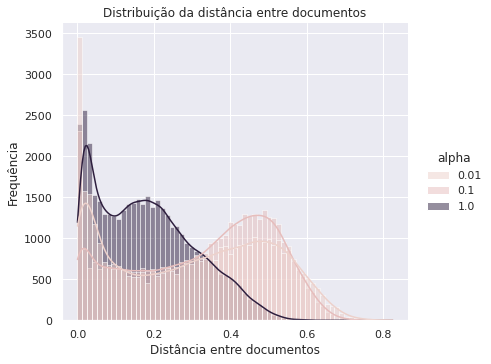

In [ ]:
resultados_explorer.distribuicao_distancias(resultados, hue='alpha')

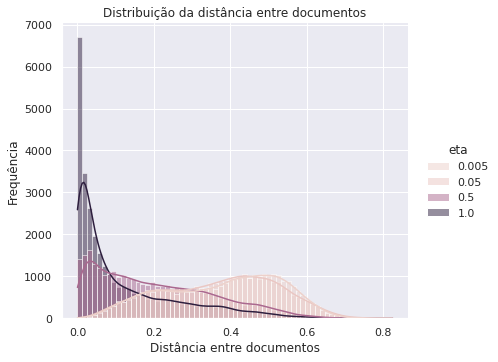

In [ ]:
resultados_explorer.distribuicao_distancias(resultados, hue='eta')

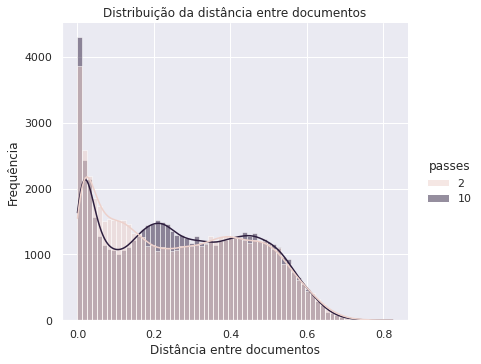

In [ ]:
resultados_explorer.distribuicao_distancias(resultados, hue='passes')

## Variação da quantidade de documentos recomendados por documento de origem

In [ ]:
grouped_origem = resultados.groupby('id_documento_origem')
grouped_origem = grouped_origem.agg({'id_documento_destino': 'nunique'}).reset_index().sort_values(by='id_documento_destino')
grouped_origem

,id_documento_origem,id_documento_destino
228,7923,43
200,7131,45
234,8116,46
199,7108,48
235,8146,51
...,...,...
250,8896,157
159,5641,158
4,134,158
120,3721,158


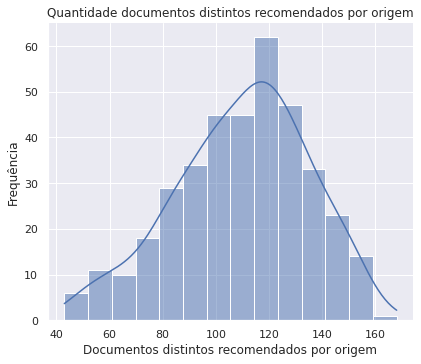

In [ ]:
ax = sns.displot(grouped_origem, x='id_documento_destino', kind='hist', aspect=1.2, kde=True)
ax.set(xlabel='Documentos distintos recomendados por origem', ylabel='Frequência', 
        title='Quantidade documentos distintos recomendados por origem')

In [ ]:
resultados_explorer.destinos_distintos_por_parametro(resultados, 'num_topics', 7)

,id_documento_origem,num_topics,id_documento_destino,possiveis
1100,5599,39,4,48.0
2534,14565,22,7,48.0
1102,5599,57,7,48.0
2535,14565,39,8,48.0
2451,13988,39,8,48.0
...,...,...,...,...
2049,10475,72,36,48.0
1753,8896,57,36,48.0
2029,10399,101,36,48.0
2592,14946,45,37,48.0


In [ ]:
resultados_explorer.destinos_distintos_por_parametro(resultados, 'alpha', 3)

,id_documento_origem,alpha,id_documento_destino,possiveis
473,5599,1.00,5,112.0
1037,13617,1.00,8,112.0
1022,13360,1.00,9,112.0
1019,13356,1.00,10,112.0
1133,15389,1.00,11,112.0
...,...,...,...,...
751,8896,0.10,76,112.0
547,6637,0.10,76,112.0
1110,14946,0.01,77,112.0
750,8896,0.01,77,112.0


In [ ]:
resultados_explorer.destinos_distintos_por_parametro(resultados, 'eta', 4)

,id_documento_origem,eta,id_documento_destino,possiveis
448,3339,0.005,15,84.0
1508,15389,0.005,15,84.0
629,5599,0.050,15,84.0
815,7185,1.000,16,84.0
1389,13870,0.050,16,84.0
...,...,...,...,...
1000,8896,0.005,57,84.0
744,6798,0.005,58,84.0
1003,8896,1.000,58,84.0
1482,14946,0.500,59,84.0


In [ ]:
resultados_explorer.destinos_distintos_por_parametro(resultados, 'passes', 2)

,id_documento_origem,passes,id_documento_destino,possiveis
314,5599,2,26,168.0
457,7923,10,27,168.0
401,7131,10,27,168.0
399,7108,10,29,168.0
469,8116,10,30,168.0
...,...,...,...,...
371,6766,10,94,168.0
373,6798,10,95,168.0
463,8018,10,96,168.0
500,8896,2,100,168.0


In [ ]:
resultados_explorer.destinos_distintos_por_parametro(resultados, 'cenario_wp', 2)

,id_documento_origem,cenario_wp,id_documento_destino,possiveis
469,8116,gte42,21,168.0
401,7131,gte42,21,168.0
457,7923,gte42,24,168.0
421,7344,gte42,24,168.0
399,7108,gte42,25,168.0
...,...,...,...,...
300,5232,full,118,168.0
296,5093,full,118,168.0
222,3326,full,120,168.0
482,8377,full,122,168.0


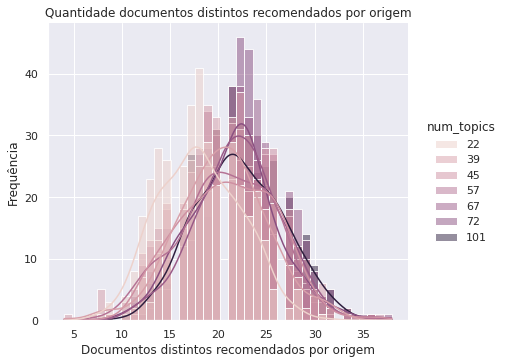

In [ ]:
resultados_explorer.distribuicao_distintos_destino_por_parametro(resultados, 'num_topics')

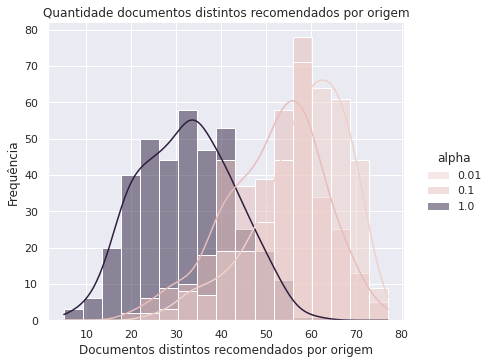

In [ ]:
resultados_explorer.distribuicao_distintos_destino_por_parametro(resultados, 'alpha')

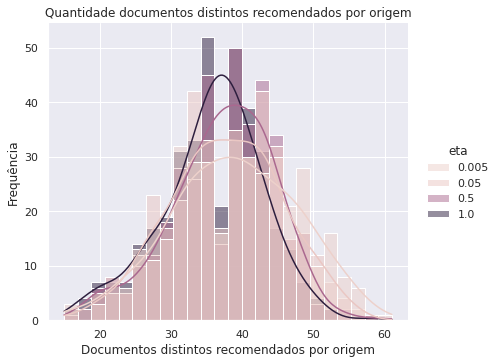

In [ ]:
resultados_explorer.distribuicao_distintos_destino_por_parametro(resultados, 'eta')

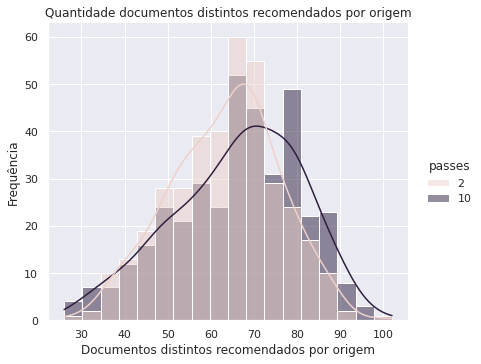

In [ ]:
resultados_explorer.distribuicao_distintos_destino_por_parametro(resultados, 'passes')

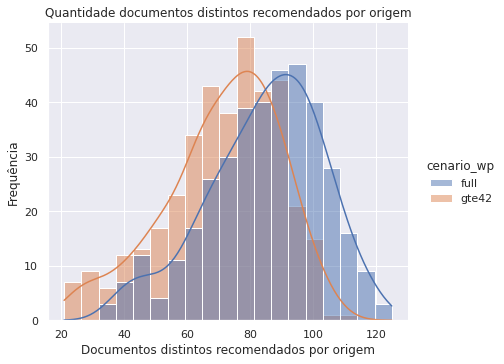

In [ ]:
resultados_explorer.distribuicao_distintos_destino_por_parametro(resultados, 'cenario_wp')

## Análise de conteúdo das recomendações

### Carregamento de dados

In [ ]:
posts_df = fonte_dados.get_dataframe()
posts_df.head(2)

In [ ]:
paginas_df = wikipedia.get_dataframe()
paginas_df.head(2)

In [ ]:
resultados_info = resultados_explorer.adicionar_informacoes_posts(resultados, posts_df, paginas_df)

(127008, 16)

### Mais recomendados para posts individuais de origem

In [ ]:
# 5599: Denali, destaque por ter poucas recomendações nos parâmetros num_topics e alplha
resultados_explorer.obter_topn_recomendacoes_por_post(resultados_info, 5599, 10)

titulo_documento_origem                                 id_documento_destino  titulo_documento_destino                     
Alasca - Visitando o Denali National Park and Preserve  1403174               Parque Nacional e Reserva de Denali              119
                                                        445474                Monte Denali                                      46
                                                        60879                 Parque Nacional de Yosemite                       41
                                                        365443                Parque Nacional de Yellowstone                    17
                                                        2726929               Dalton Highway                                     8
                                                        4365725               Ilhas ABC (Alasca)                                 6
                                                        1634725               Cerro Catedr

In [ ]:
# 5599: 3339, destaque por ter poucas recomendações no parâmetro eta
resultados_explorer.obter_topn_recomendacoes_por_post(resultados_info, 3339, 10)

titulo_documento_origem            id_documento_destino  titulo_documento_destino                               
Lençóis Maranhenses - Lagoa Verde  64980                 Reserva da Biosfera do Cinturão Verde de São Paulo         86
                                   6415856               Reserva Lagoa São Paulo                                    35
                                   5168411               Lagoa Dom Helvécio                                         20
                                   3504316               Área de Proteção Ambiental das Reentrâncias Maranhenses    13
                                   150576                Parque Nacional dos Lençóis Maranhenses                     9
                                   5773296               Campo de Perizes                                            8
                                   5307670               Balsora                                                     8
                                   1647492            

In [ ]:
# Analisando o que menos variou no geral
# id_documento_origem: 7923, quantidade de destinos_distintos: 43
resultados_explorer.obter_topn_recomendacoes_por_post(resultados_info, 7923, 10)

titulo_documento_origem  id_documento_destino  titulo_documento_destino                               
Jalapão - Alimentação    5760839               Política Nacional de Resíduos Sólidos                      62
                         4053915               Horseshoe Bend (Arizona)                                   32
                         2267850               Portal:Nova Zelândia/Colabore                              32
                         5264442               Monumento Natural das Árvores Fossilizadas do Tocantins    26
                         1971079               Projeto Cerrado Verde                                      26
                         5798789               Comissão de Negociação de Futuros de Commodities           17
                         220009                The Frighteners                                            14
                         5769507               Chapada das Mangabeiras                                    10
                         

In [ ]:
# Post que teve maior diversidade de documentos recomendados
# id_documento_origem: 6798, 168 recomendações diferentes
resultados_explorer.obter_topn_recomendacoes_por_post(resultados_info, 6798, 10)

titulo_documento_origem               id_documento_destino  titulo_documento_destino                 
Revelando a Foto - Detalhes em Caeté  176677                Bible Belt                                   8
                                      5882895               Praça Nauro Machado                          7
                                      2302257               Chonchi                                      6
                                      1083980               Rakahanga                                    5
                                      617632                Reserva Biológica Poço das Antas             5
                                      1753565               Atlas do Desenvolvimento Humano do Brasil    5
                                      5219782               Bosque Boa Vista                             5
                                      20267                 ISO 3166-2:BR                                5
                                      2179

In [ ]:
# Post que teve maior diversidade de documentos recomendados
# id_documento_origem: 3721, 158 recomendações diferentes
resultados_explorer.obter_topn_recomendacoes_por_post(resultados_info, 3721, 10)

titulo_documento_origem         id_documento_destino  titulo_documento_destino              
Revelando a Foto - Mount Moran  3176960               ISO 3166-2:NZ                             16
                                4394501               Rio Mendoza                               12
                                3322761               Channeled Scabland                         9
                                2979863               Acidente na mina de Pike River em 2010     9
                                1664923               Furacão John (1994)                        8
                                2495188               Point Barrow                               6
                                1422272               Castelo da Cinderela                       6
                                3290659               Alabama Central                            5
                                3481644               Parlamento da Nova Zelândia                5
                

In [ ]:
# O documento com id 14565 foi o que teve menor variacao com apenas 22 topicos sendo utilizados. Vamos ver o comportamento
resultados_explorer.obter_topn_recomendacoes_por_post(resultados_info, 14565, 10)

titulo_documento_origem            id_documento_destino  titulo_documento_destino     
Vídeo - Episódio Salar de Atacama  2437928               Osorno (vulcão)                  54
                                   1628545               Salar de Atacama                 51
                                   199176                Gêiseres de Tatio                37
                                   6294453               Vulcão Peña Blanca               20
                                   234193                San Pedro de Atacama             20
                                   408691                Puna atacamenha                  19
                                   131072                Lascar (vulcão)                  11
                                   2823485               Vale do Salinas                   9
                                   1634725               Cerro Catedral                    6
                                   5079095               Montanhas Rochosas 

### Analisando as 20 combinações de recomendações mais e menos frequentes

In [ ]:
resultados_info.groupby(['id_documento_origem', 'titulo_documento_origem', 'id_documento_destino', 'titulo_documento_destino']).size().sort_values(ascending=False).iloc[:20,]

id_documento_origem  titulo_documento_origem                                       id_documento_destino  titulo_documento_destino                                 
13870                Vídeo - Episódio Valle Nevado Ski Resort                      1634725               Cerro Catedral                                               159
582                  Santiago - Cerro Santa Lucía                                  2927559               Cerro Santa Lucía                                            127
5599                 Alasca - Visitando o Denali National Park and Preserve        1403174               Parque Nacional e Reserva de Denali                          119
9652                 Praia do Rosa - Trilha para o Mirante do Canto Sul            1953845               Território organizado dos Estados Unidos                     106
13583                Valle Nevado Ski Resort - Minha Experiência com o Esqui       1634725               Cerro Catedral                                      

In [ ]:
resultados_info.groupby(['id_documento_origem', 'titulo_documento_origem', 'id_documento_destino', 'titulo_documento_destino']).size().sort_values(ascending=True).iloc[:20,]

id_documento_origem  titulo_documento_origem                        id_documento_destino  titulo_documento_destino                 
15389                Catas Altas - Um Passeio Pela Cidade e Região  6601506               Parque Estadual de Grão Mogol                1
3448                 Revelando a Foto - Dia das Crianças            2895968               Lista de vencedoras do Miss USA              1
9409                 Revelando a Foto - Flores no Epcot             2661198               Lista de rios dos Estados Unidos             1
                                                                    2643539               Rio Anatoki                                  1
3448                 Revelando a Foto - Dia das Crianças            3157366               25.º Distrito Congressional da Califórnia    1
9409                 Revelando a Foto - Flores no Epcot             2643359               Rio Allen                                    1
                                              

In [ ]:
resultados_info.groupby(['id_documento_origem', 'titulo_documento_origem', 'id_documento_destino', 'titulo_documento_destino', 'num_topics']).size().sort_values(ascending=False).iloc[:20,]

id_documento_origem  titulo_documento_origem                                      id_documento_destino  titulo_documento_destino                       num_topics
5599                 Alasca - Visitando o Denali National Park and Preserve       1403174               Parque Nacional e Reserva de Denali            39            34
6212                 Alasca - Vida Selvagem no Denali National Park and Preserve  1403174               Parque Nacional e Reserva de Denali            39            31
663                  Frutillar - Um Pedaço da Alemanha no Chile                   570874                Frutillar                                      57            29
4120                 Revelando a Foto - Horseshoe Bend                            4053915               Horseshoe Bend (Arizona)                       57            28
582                  Santiago - Cerro Santa Lucía                                 2927559               Cerro Santa Lucía                              67            2

In [ ]:
resultados_info.groupby(['id_documento_origem', 'titulo_documento_origem', 'id_documento_destino', 'titulo_documento_destino', 'alpha']).size().sort_values(ascending=False).iloc[:20,]

id_documento_origem  titulo_documento_origem                                       id_documento_destino  titulo_documento_destino              alpha
13360                Parque Estadual do Rio Preto - O Que Fazer?                   341897                Parque Estadual da Serra do Cabral    1.00     70
13870                Vídeo - Episódio Valle Nevado Ski Resort                      1634725               Cerro Catedral                        1.00     63
582                  Santiago - Cerro Santa Lucía                                  2927559               Cerro Santa Lucía                     0.10     61
14612                Vídeo - Episódio Laguna Torre                                 588018                Monte Fitz Roy                        1.00     56
14090                Hard Rock Hotel & Casino Punta Cana - Suíte Caribe            1152952               American Academy of Arts and Letters  1.00     56
14103                Punta Cana - Hard Rock Hotel & Casino Punta Cana       

In [ ]:
resultados_info.groupby(['id_documento_origem', 'titulo_documento_origem', 'id_documento_destino', 'titulo_documento_destino', 'eta']).size().sort_values(ascending=False).iloc[:20,]

id_documento_origem  titulo_documento_origem                                  id_documento_destino  titulo_documento_destino                            eta  
13870                Vídeo - Episódio Valle Nevado Ski Resort                 1634725               Cerro Catedral                                      0.050    62
                                                                                                                                                        0.005    51
3428                 Lençóis Maranhenses - Post Índice                        64980                 Reserva da Biosfera do Cinturão Verde de São Paulo  0.005    50
3339                 Lençóis Maranhenses - Lagoa Verde                        64980                 Reserva da Biosfera do Cinturão Verde de São Paulo  0.005    47
5599                 Alasca - Visitando o Denali National Park and Preserve   1403174               Parque Nacional e Reserva de Denali                 0.050    43
2994                 L

In [ ]:
resultados_info.groupby(['id_documento_origem', 'titulo_documento_origem', 'id_documento_destino', 'titulo_documento_destino', 'passes']).size().sort_values(ascending=False).iloc[:20,]

id_documento_origem  titulo_documento_origem                                            id_documento_destino  titulo_documento_destino                                   passes
13870                Vídeo - Episódio Valle Nevado Ski Resort                           1634725               Cerro Catedral                                             10        87
14103                Punta Cana - Hard Rock Hotel & Casino Punta Cana                   1152952               American Academy of Arts and Letters                       10        74
13870                Vídeo - Episódio Valle Nevado Ski Resort                           1634725               Cerro Catedral                                             2         72
14090                Hard Rock Hotel & Casino Punta Cana - Suíte Caribe                 1152952               American Academy of Arts and Letters                       10        66
582                  Santiago - Cerro Santa Lucía                                       2927559 

In [ ]:
resultados_info.groupby(['id_documento_origem', 'titulo_documento_origem', 'id_documento_destino', 'titulo_documento_destino', 'cenario_wp']).size().sort_values(ascending=False).iloc[:20,]

id_documento_origem  titulo_documento_origem                                       id_documento_destino  titulo_documento_destino                                   cenario_wp
13870                Vídeo - Episódio Valle Nevado Ski Resort                      1634725               Cerro Catedral                                             gte42         100
582                  Santiago - Cerro Santa Lucía                                  2927559               Cerro Santa Lucía                                          gte42          77
2469                 Revelando a Foto - Antelope Canyon                            788767                Antelope Canyon                                            full           69
5599                 Alasca - Visitando o Denali National Park and Preserve        1403174               Parque Nacional e Reserva de Denali                        gte42          68
1748                 Região dos Lagos Chilenos - Roteiro Volta ao Lago Llanquihue  2267833       

### Análise geral por recomendado

In [ ]:
# resultados_info.groupby(['id_documento_destino', 'titulo_documento_destino']).size().sort_values(ascending=False).iloc[:20,]
origem_destino_distintos = resultados_info[['id_documento_destino', 'titulo_documento_destino', 'id_documento_origem', 'titulo_documento_origem']].drop_duplicates()

In [ ]:
posts_distintos_origem_por_destino = origem_destino_distintos.groupby(['id_documento_destino', 'titulo_documento_destino']).size()

In [ ]:
"""
Paginas da wikipedia que foram recomendadas para mais posts de origem distintos.
"""
posts_distintos_origem_por_destino.sort_values(ascending=False)[:20, ]

id_documento_destino  titulo_documento_destino                          
4053915               Horseshoe Bend (Arizona)                              174
3176960               ISO 3166-2:NZ                                         149
1393890               Glaciar Taku                                          148
2960687               Lista de premiações especiais do Miss USA             140
1422272               Castelo da Cinderela                                  138
588018                Monte Fitz Roy                                        130
1403174               Parque Nacional e Reserva de Denali                   130
3237051               ISO 3166-2:CL                                         120
2192702               Glaciar Upsala                                        120
5661481               Lago Yellowstone                                      117
2895572               Praça Pedro II (São Luís)                             116
3067469               Área de Estatística Combi

<AxesSubplot:>

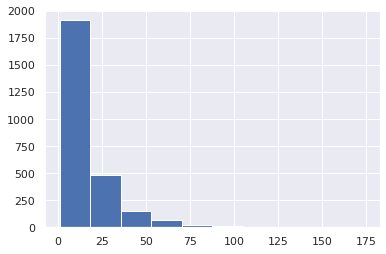

In [ ]:
posts_distintos_origem_por_destino.sort_values(ascending=False).hist()

In [ ]:
"""
Analise de posts para os quais Horseshoe Bend (Arizona) foi recomendado como mais semelhante (id: 4053915)

174 origem distintos, 1511 recomendações no total

ESTE É UM EXCELENTE CANDIDATO A ENTENDER A SEMELHANÇA POR CAUSA DOS POSTS CERTEIROS NO INICIO E OS 8 DO JALAPAO EM SEGUIDA
"""
resultados_explorer.obter_topn_posts_por_recomendado(resultados_info, 4053915, 10)

(1511, 16)


id_documento_origem  titulo_documento_origem          
4120                 Revelando a Foto - Horseshoe Bend    96
7412                 Revelando a Foto - Lake Powell       49
6863                 Jalapão - Cânion Sussuapara          34
7911                 Jalapão - Transporte                 33
7923                 Jalapão - Alimentação                32
7108                 Jalapão - Fervedouro da Glorinha     32
7185                 Jalapão - Cachoeira da Formiga       32
6823                 Jalapão - O que vem por aí           31
8116                 Jalapão - O que Levar?               31
8146                 Jalapão - Acampamento Korubo         31
dtype: int64

In [ ]:
"""
Analise de posts para os quais a página Campo de Gelo Sul da Patagonia foi recomendado como mais semelhante (id: 1393635)

99 origem distintos, 390 recomendações no total
"""
resultados_explorer.obter_topn_posts_por_recomendado(resultados_info, 1393635, 10)

(390, 16)


id_documento_origem  titulo_documento_origem                                    
4152                 Kenai Fjords National Park - Trilha para o Harding Icefield    21
7723                 El Calafate - Passeio de Barco por Todos Los Glaciares          9
3772                 Kenai Fjords National Park - Passeio de Barco no Alasca         9
3756                 Kenai Fjords National Park - Trilha do Exit Glacier             9
15034                Cachoeira da Maçã, Bela Surpresa da Cabeça de Boi               8
2421                 Revelando a Foto - Barco no Lago Espejo Chico                   8
2137                 Do Chile a Argentina sob Cinzas Vulcânicas                      8
7560                 El Calafate - Tour ao Glaciar Perito Moreno                     8
11254                El Calafate - Estancia Cristina                                 7
9079                 Circuito W - Lago e Glaciar Grey                                7
dtype: int64

In [ ]:
# Fit Roy
resultados_explorer.obter_topn_posts_por_recomendado(resultados_info, 588018, 10)

(1348, 16)


id_documento_origem  titulo_documento_origem                              
14612                Vídeo - Episódio Laguna Torre                            77
14598                Vídeo - Episódio Laguna de Los Tres                      74
10340                El Chalten - Trilha para a Loma del Pliegue Tumbado      68
10948                Revelando a Foto - Laguna de Los Tres                    64
12287                El Chaltén - Volta à Laguna de los Tres                  51
9829                 El Chaltén - Trilha para Laguna Torre                    45
10141                El Chaltén - Trilha para Laguna de los Tres              40
7544                 Revelando a Foto - Patagônia sem Filtro                  38
12362                El Chalten - Trilha para a Laguna del Diablo             36
13282                Belo Horizonte - Visita ao Pátio Cervejeiro da Backer    35
dtype: int64

In [ ]:
# 1403174 Parque Nacional e Reserva de Denali
resultados_explorer.obter_topn_posts_por_recomendado(resultados_info, 1403174, 10)

(1119, 16)


id_documento_origem  titulo_documento_origem                                       
5599                 Alasca - Visitando o Denali National Park and Preserve            119
6212                 Alasca - Vida Selvagem no Denali National Park and Preserve        93
1356                 Bariloche - Cerro Tronador e Cascada los Alerces                   54
1772                 Revelando a Foto - Parque das Aves                                 38
768                  Parque Nacional Lanín - Passeando entre Lagos e o Vulcão Lanín     37
5945                 De Anchorage ao Denali - Dirigindo pela Alaska Highway 3           31
12563                Islândia - Como Organizar uma Viagem de Campervan                  29
13583                Valle Nevado Ski Resort - Minha Experiência com o Esqui            28
392                  Revelando a Foto - Arches National Park                            27
1020                 Barcelona - Parc Güell                                             23
dtype:

In [ ]:
# 5661481 Lago Yellowstone
resultados_explorer.obter_topn_posts_por_recomendado(resultados_info, 5661481, 10)

(443, 16)


id_documento_origem  titulo_documento_origem                                     
11322                Revelando a Foto - Reflexos no Barco                            12
9059                 Revelando a Foto - Inspiration Point no Bryce Canyon            12
1357                 Rota dos Sete Lagos - De Bariloche a San Martín de los Andes    10
2313                 Revelando a Foto - Parque Nacional Lanín                        10
972                  Revelando a Foto - Lago Meliquina                               10
7564                 Revelando a Foto - Riacho do Glaciar Huemul                      9
9079                 Circuito W - Lago e Glaciar Grey                                 9
10009                El Chaltén - Trilha para o Chorrillo del Salto                   7
8459                 Revelando a Foto - Rio de Las Vueltas                            6
11119                Revelando a Foto - Trekking no Glaciar Perito Moreno             6
dtype: int64

In [ ]:
# 2203643 Deserto de Chihuahua
resultados_explorer.obter_topn_posts_por_recomendado(resultados_info, 2203643, 10)

(247, 16)


id_documento_origem  titulo_documento_origem                            
3290                 Atins - O Famoso Camarão da Luzia                      19
9829                 El Chaltén - Trilha para Laguna Torre                  10
12287                El Chaltén - Volta à Laguna de los Tres                10
10141                El Chaltén - Trilha para Laguna de los Tres            10
10340                El Chalten - Trilha para a Loma del Pliegue Tumbado     9
14598                Vídeo - Episódio Laguna de Los Tres                     8
14612                Vídeo - Episódio Laguna Torre                           8
12609                Quando ir para a Islândia                               7
1960                 Chile - Não Durma no Voo                                7
10948                Revelando a Foto - Laguna de Los Tres                   6
dtype: int64

## Explicação da semelhança

In [ ]:
def get_tokens_documentos(df, ids_docs):
    return df[df['id_documento'].isin(ids_docs)]['tokens']

Alvos:
- Destino horseshoe bend: 4053915
- Origens
    * 4120 (Revelando a Foto - Horseshoe Bend)
    * 7412 (Revelando a Foto - Lake Powell)
    * 6863 (Jalapão - Cânion Sussuapara)
    * 7911 (Jalapão - Transporte)

In [ ]:
tokens_origens = get_tokens_documentos(posts_df, [4120, 7412, 6863, 7911, 7923, 7108, 7185, 6823, 8116, 8146]).to_numpy()
corpus_horseshoe = [resultado_lda.dicionario.doc2bow(d) for d in tokens_origens]
print('Topicos dominantes dos documentos de origem')
topico_dominante.print_topn_topics(lda_model, corpus_horseshoe)

print('Topicos dominantes dos documentos de destino')
tokens_destinos = get_tokens_documentos(paginas_df, [4053915]).to_numpy()
corpus_destino = [resultado_lda.dicionario.doc2bow(d) for d in tokens_destinos]
topico_dominante.print_topn_topics(lda_model, corpus_destino)

Topicos dominantes dos documentos de origem
['16 = 0.9357', '25 = 0.0576', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001']
['16 = 0.9919', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
['16 = 0.9957', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
['16 = 0.9949', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
['16 = 0.9950', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
['29 = 0.6962', '16 = 0.2232', '56 = 0.0739', '0 = 0.0001', '1 = 0.0001']
['16 = 0.9953', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
['16 = 0.9952', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
['16 = 0.9944', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
['16 = 0.6336', '53 = 0.3612', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001']
Topicos dominantes dos documentos de destino
['16 = 0.4912', '29 = 0.1190', '19 = 0.1015', '20 = 0.0756', '52 = 0.0586']


In [ ]:
topico_dominante.print_words_by_topic(lda_model, [16, 29])

['jalap = 0.1216', 'cacho = 0.0302', 'águ = 0.0170', 'korub = 0.0168', 'velh = 0.0149', 'pra = 0.0140', 'temp = 0.0133', 'lei = 0.0125', 'expos = 0.0118', 'dun = 0.0109']
['vall = 0.0314', 'esqu = 0.0204', 'cidad = 0.0146', 'tr = 0.0141', 'lagun = 0.0123', 'aul = 0.0103', 'fiz = 0.0098', 'ski = 0.0092', 'pouc = 0.0089', 'santiag = 0.0088']


### Análise topicos palavras Laguna Verde

- Origem: 3339 (Lençois Maranhenses - Laguna Verde)
- Destinos:
    * 64980 (Reserva da Biosfera do Cinturão Verde de São Paulo) 86
    * 6415856 (Reserva Lagoa São Paulo) 35
    * 5168411 (Lagoa Dom Helvécio) 20
    * 3504316 Área de Proteção Ambiental das Reentrâncias Maranhenses) 13
    * 150576 (Parque Nacional dos Lençóis Maranhenses) 9

In [ ]:
tokens_origens = get_tokens_documentos(posts_df, [3339]).to_numpy()
corpus_horseshoe = [resultado_lda.dicionario.doc2bow(d) for d in tokens_origens]
print('Topicos dominantes dos documentos de origem')
topico_dominante.print_topn_topics(lda_model, corpus_horseshoe)

print('Topicos dominantes dos documentos de destino')
tokens_destinos = get_tokens_documentos(paginas_df, [64980, 6415856, 5168411, 3504316, 150576]).to_numpy()
corpus_destino = [resultado_lda.dicionario.doc2bow(d) for d in tokens_destinos]
topico_dominante.print_topn_topics(lda_model, corpus_destino)

Topicos dominantes dos documentos de origem
['23 = 0.9969', '0 = 0.0001', '1 = 0.0001', '2 = 0.0001', '3 = 0.0001']
Topicos dominantes dos documentos de destino
['5 = 0.1444', '48 = 0.1266', '1 = 0.1034', '56 = 0.0746', '47 = 0.0629']
['1 = 0.3183', '23 = 0.3118', '3 = 0.2009', '47 = 0.1232', '7 = 0.0327']
['1 = 0.1432', '23 = 0.1187', '48 = 0.1097', '5 = 0.0999', '32 = 0.0934']
['48 = 0.2409', '5 = 0.1652', '25 = 0.0726', '17 = 0.0638', '23 = 0.0561']
['48 = 0.3250', '23 = 0.1634', '7 = 0.1089', '32 = 0.0857', '30 = 0.0781']


In [ ]:
topico_dominante.print_words_by_topic(lda_model, [23, 0, 1])

['lago = 0.0629', 'verd = 0.0171', 'águ = 0.0166', 'prat = 0.0150', 'pouc = 0.0146', 'lençol = 0.0141', 'gent = 0.0127', 'barre = 0.0126', 'cidad = 0.0113', 'maranh = 0.0112']
['urs = 0.0228', 'iso = 0.0163', 'boa = 0.0153', 'câm = 0.0152', 'parqu = 0.0136', 'cinderel = 0.0109', 'moment = 0.0101', 'voad = 0.0098', 'voo = 0.0096', 'cordilh = 0.0088']
['sorvet = 0.0164', 'cidad = 0.0127', 'aind = 0.0094', 'histór = 0.0062', 'mund = 0.0062', 'uma = 0.0061', 'pouc = 0.0059', 'pesso = 0.0057', 'são = 0.0056', 'temp = 0.0055']
